# Pathway Overview 

This file is happening after enrichment analysis for 2 conditions, i.e. lac01_vs_lac25, lac50_vs_lac25.

The goal for this file is a combination of:

    - up/down-regulated percentage of genes in a pathway for each pathway. 
    - calculate a similarity score between conditions for each pathway, here I would use pearson correlation as it have a maximum of 1
    - NES from the enrichment analysis, which is the normalized enrichment score. 

# 1. Load 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

### 1.1 Data files

In [5]:
# the pathways gene dictionary file
pathway_gene_dict_file = "HelpFiles/Ecyc_NCBI_pathways.csv"

lac01_vs_lac25_de_file = "../1-DEAnalyz/DE-CSVs/pre_lac25/pre_lac01_vs_pre_lac25.csv"
lac50_vs_lac25_de_file = "../1-DEAnalyz/DE-CSVs/pre_lac25/pre_lac50_vs_pre_lac25.csv"

In [6]:
pathway_gene_dict = pd.read_csv(pathway_gene_dict_file, header = 0, index_col=0).reset_index(drop= True)
lac01_vs_lac25_de = pd.read_csv(lac01_vs_lac25_de_file, header = 0, index_col=None).reset_index(drop= True)
lac50_vs_lac25_de = pd.read_csv(lac50_vs_lac25_de_file, header = 0, index_col=None).reset_index(drop= True)

### 1.2 Pathway info missing data

In [7]:
pathway_gene_dict.head(3)

,UNIQUE-ID,NAME,gene_all
0,BGALACT-PWY,lactose degradation III,ECB_RS01575
1,DAPLYSINESYN-PWY,lysine biosynthesis I,"ECB_RS19505,ECB_RS14205,ECB_RS12455,ECB_RS16990,ECB_RS00855,ECB_RS12495,ECB_RS17375,ECB_RS20715,ECB_RS20285,ECB_RS00010,ECB_RS00170"
2,PWY-1269,CMP-KDO biosynthesis I,"ECB_RS04870,ECB_RS14890,ECB_RS16185,ECB_RS06320,ECB_RS16180,ECB_RS13525"


In [8]:
pathway_gene_dict[pathway_gene_dict.gene_all.isna()]

,UNIQUE-ID,NAME,gene_all
82,PWY-5443,aminopropanol phosphate biosynthesis I,NaN
83,PWY-5794,malonate degradation I (biotin-independent),NaN
131,PWY-3982,uracil degradation I (reductive),NaN
132,PWY-5155,&beta;-alanine biosynthesis III,NaN
161,HISTDEG-PWY,histidine degradation IV,NaN
334,PWY-6430,thymine degradation,NaN


There are 6 pathways that don't have any gene inside them. 

They might be the pathway catagory, or redundant/wrong info. Thus I would discard them.

In [9]:
pathway_gene_nomissing = pathway_gene_dict[~pathway_gene_dict.gene_all.isna()].copy().reset_index(drop=True)
pathway_gene_nomissing.head(3)

,UNIQUE-ID,NAME,gene_all
0,BGALACT-PWY,lactose degradation III,ECB_RS01575
1,DAPLYSINESYN-PWY,lysine biosynthesis I,"ECB_RS19505,ECB_RS14205,ECB_RS12455,ECB_RS16990,ECB_RS00855,ECB_RS12495,ECB_RS17375,ECB_RS20715,ECB_RS20285,ECB_RS00010,ECB_RS00170"
2,PWY-1269,CMP-KDO biosynthesis I,"ECB_RS04870,ECB_RS14890,ECB_RS16185,ECB_RS06320,ECB_RS16180,ECB_RS13525"


In [10]:
pathway_gene_dict.shape, pathway_gene_nomissing.shape

((368, 3), (362, 3))

In [11]:
lac01_vs_lac25_de.head(3)

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj
0,ECB_RS09245,328.602032,5.875928,0.204219,2.943970e-184,1.321254e-180
1,ECB_RS10510,538.984116,8.290076,0.321395,1.842158e-147,4.133804e-144
2,ECB_RS09060,339.415477,7.670713,0.312262,9.190955e-136,1.374967e-132


In [12]:
lac50_vs_lac25_de.head(3)

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj
0,ECB_RS05720,158.394465,-3.118403,0.139206,2.348974e-112,1.054220e-108
1,ECB_RS05725,205.024271,-2.868180,0.141371,2.929798e-92,6.574466e-89
2,ECB_RS05520,146.421764,-4.679882,0.251290,9.875293e-79,1.477344e-75


### 1.1 Selecting data which adj p-value (FDR) less than 0.05

In [13]:
lac01_vs_lac25_de_sig = lac01_vs_lac25_de[(lac01_vs_lac25_de.padj<0.05) & (lac01_vs_lac25_de.log2FoldChange.abs()>1)].copy().reset_index(drop= True)
lac50_vs_lac25_de_sig = lac50_vs_lac25_de[(lac50_vs_lac25_de.padj<0.05) & (lac50_vs_lac25_de.log2FoldChange.abs()>1)].copy().reset_index(drop= True)

In [14]:
lac01_vs_lac25_de.shape, lac01_vs_lac25_de_sig.shape

((4490, 6), (2990, 6))

In [15]:
lac50_vs_lac25_de.shape, lac50_vs_lac25_de_sig.shape

((4490, 6), (2585, 6))

# 2. Functions

### 2.1 Percentatges of up and down regulated genes

In [16]:
def upreg_percentage(pathway_info, dataframe, col_id, col_lfc, new_col_name):
    """
    Describe: The function takes in pathway info and dataframe, 
              and then return a dataframe of percentage of 
              upregulated genes
    Input:
        pathway_info - (pd.DataFrame)
        dataframe - (pd.DataFrame)
        col_id - (string)
        col_lfc - (string)
    """
    
    percentage = []
    i = 0
    while i<len(pathway_info):
        # obtaining gene set list from the pathway dataframe
        try:
            gene_set = pathway_info.loc[i, "gene_all"].split(",")
        except: 
            print(pathway_info.loc[i, "gene_all"], print(pathway_info.iloc[i,]))
            return 1
        #print(gene_set)
        
        # check if the DEG in that list.
        exist_gene = []
        exist_lfc  = []
        
        j = 0
        while j< len(dataframe):
            
            gene_id = dataframe.loc[j, col_id]
            gene_lfc = float(dataframe.loc[j, col_lfc])
            
            if (gene_id in gene_set) and (gene_lfc>0):
                exist_gene.append(gene_id)
                exist_lfc.append(gene_lfc)
            
            j = j+1
            
        len_up = len(exist_gene)
        len_total = len(gene_set)
        percentage.append(float(len_up)/float(len_total))
        
        i = i+1
    
    up_percent_df = pd.DataFrame({
        "pathway_id": pathway_info["UNIQUE-ID"],
        new_col_name: percentage
    })
    
    return up_percent_df

In [17]:
def downreg_percentage(pathway_info, dataframe, col_id, col_lfc, new_col_name):
    """
    Describe: The function takes in pathway info and dataframe, 
              and then return a dataframe of percentage of 
              downregulated genes
    Input:
        pathway_info - (pd.DataFrame)
        dataframe - (pd.DataFrame)
        col_id - (string)
        col_lfc - (string)
    """
    
    percentage = []
    i = 0
    while i<len(pathway_info):
        # obtaining gene set list from the pathway dataframe
        try:
            gene_set = pathway_info.loc[i, "gene_all"].split(",")
        except: 
            print(pathway_info.loc[i, "gene_all"], print(pathway_info.iloc[i,]))
            return 1
        #print(gene_set)
        
        # check if the DEG in that list.
        exist_gene = []
        exist_lfc  = []
        
        j = 0
        while j< len(dataframe):
            
            gene_id = dataframe.loc[j, col_id]
            gene_lfc = float(dataframe.loc[j, col_lfc])
            
            if (gene_id in gene_set) and (gene_lfc<0):
                exist_gene.append(gene_id)
                exist_lfc.append(gene_lfc)
            
            j = j+1
            
        len_down = len(exist_gene)
        len_total = len(gene_set)
        percentage.append(float(len_down)/float(len_total))
        
        i = i+1
    
    up_percent_df = pd.DataFrame({
        "pathway_id": pathway_info["UNIQUE-ID"],
        new_col_name: percentage
    })
    
    return up_percent_df

In [18]:
upreg_lac01 = upreg_percentage(pathway_gene_nomissing, lac01_vs_lac25_de_sig, 
                 "Unnamed: 0", "log2FoldChange", "lac01_up_percentage")

upreg_lac50 = upreg_percentage(pathway_gene_nomissing, lac50_vs_lac25_de_sig, 
                 "Unnamed: 0", "log2FoldChange", "lac50_up_percentage")

In [19]:
downreg_lac01 = downreg_percentage(pathway_gene_nomissing, lac01_vs_lac25_de_sig, 
                 "Unnamed: 0", "log2FoldChange", "lac01_down_percentage")

downreg_lac50 = downreg_percentage(pathway_gene_nomissing, lac50_vs_lac25_de_sig, 
                 "Unnamed: 0", "log2FoldChange", "lac50_down_percentage")

In [20]:
upreg_lac01.describe()

,lac01_up_percentage
count,362.000000
mean,0.317452
std,0.374392
min,0.000000
25%,0.000000
50%,0.166667
75%,0.500000
max,1.000000


<AxesSubplot:>

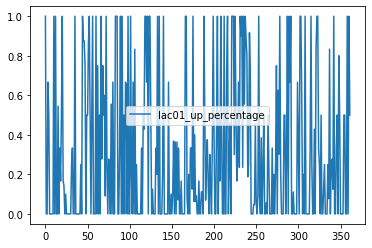

In [21]:
upreg_lac01.plot()

In [22]:
upreg_lac50.describe()

,lac50_up_percentage
count,362.000000
mean,0.268836
std,0.359532
min,0.000000
25%,0.000000
50%,0.009346
75%,0.500000
max,1.000000


<AxesSubplot:>

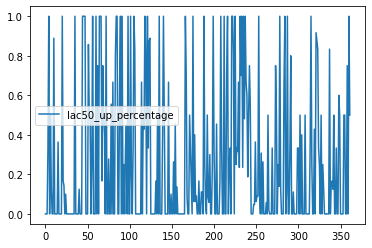

In [23]:
upreg_lac50.plot()

In [24]:
downreg_lac01.describe()

,lac01_down_percentage
count,362.000000
mean,0.395379
std,0.371640
min,0.000000
25%,0.000000
50%,0.333333
75%,0.705882
max,1.000000


<AxesSubplot:>

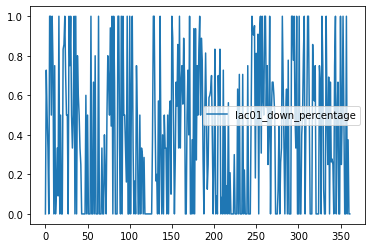

In [25]:
downreg_lac01.plot()

In [26]:
downreg_lac50.describe()

,lac50_down_percentage
count,362.000000
mean,0.306426
std,0.331156
min,0.000000
25%,0.000000
50%,0.250000
75%,0.500000
max,1.000000


<AxesSubplot:>

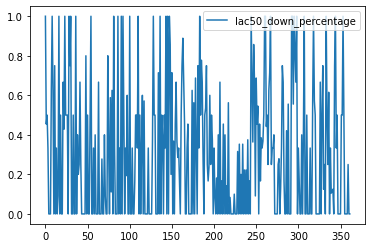

In [27]:
downreg_lac50.plot()

 ### 2.2 Function for similarities.

In [28]:
# for unify the pearson correlations
def unit_fy(list):
    # for a given list, change the number to a unit number
    # >1 := 1
    # -1<~<1 := 0
    # <-1 := -1
    series = pd.Series(list)
    #print(series[series>=1])
    series[series.abs()<1] = 0.
    series[series>=1] = 1.
    series[series<=-1]= -1
    
#     series = series.replace(series[(series<1)&(series>-1)], 0.)
#     series = series.replace(series[series>=1], 1)
#     series = series.replace(series[series<=-1], -1)
    #print(series)
    return(series)

In [33]:
def pwy_similarity(pwy_info, df1, col_id1, col_lfc1, df2, col_id2, col_lfc2, similar_col_name):
        """
        Describe: for given condition df, pwy info, col names, return pwy smilarity with pearson.
        Input:
            pwy_info - (pd.DataFrame)
            df1 - (pd.DataFrame)
            col_id1 - (string) 
            col_lfc1 - (string) 
            df2 - (pd.DataFrame) 
            col_id2 - (string) 
            col_lfc2 - (string)
        Output: similarity dataframe - (pd.DataFrame)
        """
        all_genes1 = df1[col_id1].tolist()    # gene list for df1
        all_genes2 = df2[col_id2].tolist()
        similarity_list = []
        sim_p_value = []
        pwy_id = []
        
        i = 0
        while i<len(pwy_info):
            
            gene_set = pwy_info.loc[i, "gene_all"].split(",")
            lfc1_list = []
            lfc2_list = []
            
            if len(gene_set)>=2:
                
                pwy_id.append(pwy_info.loc[i, "UNIQUE-ID"])
                for gene in gene_set:

                    if gene in all_genes1:
                        lfc1 = float(df1[df1[col_id1]==gene][col_lfc1].values[0])
                        #print(lfc1)
                    else:
                        lfc1 = 0.0
                    if gene in all_genes2:
                        lfc2 = float(df2[df2[col_id2]==gene][col_lfc2].values[0])                    
                        #print(lfc2)
                    else:
                        lfc2 = 0.0

                    lfc1_list.append(lfc1)
                    lfc2_list.append(lfc2)
                
            if len(gene_set)>=2:
                #print(lfc1_list, lfc2_list)
                #unit_lfc1_list = unit_fy(lfc1_list)
                #unit_lfc2_list = unit_fy(lfc2_list)
                
                unit_lfc1_list = lfc1_list
                unit_lfc2_list = lfc2_list
                #print(unit_lfc1_list)
                rho, p = spearmanr(unit_lfc1_list, unit_lfc2_list)
                #similarity = pearsonr(unit_lfc1_list, unit_lfc2_list)
                
                if rho<0.:
                    k = 0
                    sim_local = 0
                    while k<len(unit_lfc1_list):
                        "This is the case where we have the rank are opposite, but the direction are the same."
                        if unit_lfc1_list[k]*unit_lfc2_list[k]>0:
                            sim_local = sim_local+1
                        k = k+1
                    if sim_local == len(unit_lfc1_list):
                        rho = 1
                similarity_list.append(rho)
                sim_p_value.append(p)
                #print(similarity, "\n")
            
            i = i+1
            
        similarity_df = pd.DataFrame(
            {
                "pwy_id": pwy_id,
                similar_col_name: similarity_list,
                similar_col_name + "_p_value": sim_p_value
            }
        )
        
        return similarity_df

In [34]:
lac01_vs_lac25_de_sig

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj
0,ECB_RS09245,328.602032,5.875928,0.204219,2.943970e-184,1.321254e-180
1,ECB_RS10510,538.984116,8.290076,0.321395,1.842158e-147,4.133804e-144
2,ECB_RS09060,339.415477,7.670713,0.312262,9.190955e-136,1.374967e-132
3,ECB_RS07420,240.525011,7.522753,0.312940,1.723886e-130,1.934200e-127
4,ECB_RS21750,230.379194,5.346168,0.226011,1.840229e-125,1.651789e-122
...,...,...,...,...,...,...
2985,ECB_RS02495,15.875378,1.074046,0.595857,3.359850e-02,4.228549e-02
2986,ECB_RS06050,4.044662,1.323153,0.874582,3.565853e-02,4.466522e-02
2987,ECB_RS21550,7.834177,1.073710,0.631954,3.682736e-02,4.607783e-02
2988,ECB_RS17420,9.924475,1.069187,0.647678,3.745116e-02,4.681917e-02


In [35]:
sim_50_01 = pwy_similarity(
    pathway_gene_nomissing,
    lac01_vs_lac25_de_sig, "Unnamed: 0", "log2FoldChange",
    lac50_vs_lac25_de_sig, "Unnamed: 0", "log2FoldChange",
    "lac50_lac01_similarity"
)

/Users/huijing/opt/anaconda3/envs/rna/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [36]:
sim_50_01=sim_50_01.rename(columns = {'pwy_id':'pathway_id'})

array([[<AxesSubplot:title={'center':'lac50_lac01_similarity'}>,
        <AxesSubplot:title={'center':'lac50_lac01_similarity_p_value'}>]],
      dtype=object)

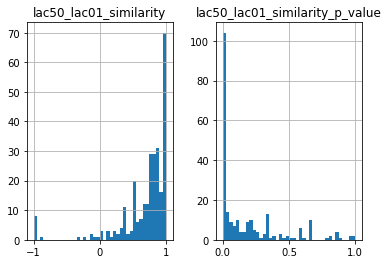

In [37]:
sim_50_01.hist(bins = 40)

### 2.3 NES for each pathway enrichment

In [40]:
lac50_enrich_file = "(no amp)EnrichFiles/lac50_vs_lac25.csv"
lac01_enrich_file = "(no amp)EnrichFiles/lac01_vs_lac25.csv"

lac50_enrich = pd.read_csv(lac50_enrich_file, header = 0, index_col=0)
lac01_enrich = pd.read_csv(lac01_enrich_file, header = 0, index_col=0)

In [41]:
lac50_enrich_sig = lac50_enrich[lac50_enrich.padj<0.05].copy()[["pathway", "NES"]]
lac01_enrich_sig = lac01_enrich[lac01_enrich.padj<0.05].copy()[["pathway", "NES"]]

lac50_enrich_sig.columns = ["pathway_id", "lac50_NES"]
lac01_enrich_sig.columns = ["pathway_id", "lac01_NES"]

# 3. 

### 3.1 Merging dataframe

percentages:

    upreg_lac01
    upreg_lac50 
    downreg_lac01
    downreg_lac50 
    
Similarities:

    sim_50_01

Enrichment:

    lac50_enrich_sig
    lac01_enrich_sig

In [42]:
upreg_lac01.head(3)

,pathway_id,lac01_up_percentage
0,BGALACT-PWY,1.0
1,DAPLYSINESYN-PWY,0.0
2,PWY-1269,0.0


In [43]:
sim_50_01.head(3)

,pathway_id,lac50_lac01_similarity,lac50_lac01_similarity_p_value
0,DAPLYSINESYN-PWY,0.570285,0.066968
1,PWY-1269,0.935484,0.006109
2,CYANCAT-PWY,1.000000,0.000000


In [44]:
def simple_merge(df_list, col_id):
    """
    Describe: Simple merge function
    input: 
        df_list - (list of pd.DataFrame)
        id_list - (list of string)
    return:
        merge_df - (pd.DataFrame)
    """
    
    merge_df = pd.merge(
        left = df_list[0],
        right = df_list[1],
        how = "left",
        on = col_id
    )
    
    i = 2
    while i<len(df_list):
        
        merge_df = pd.merge(
            left = merge_df,
            right = df_list[i],
            how = "left",
            on = col_id
        )
        
        i = i+1
        
    return merge_df

In [45]:
df_list = [upreg_lac01, upreg_lac50 , 
           downreg_lac01, downreg_lac50, 
           sim_50_01, 
           lac50_enrich_sig, lac01_enrich_sig]
col_id = "pathway_id"
pwy_merge_df = simple_merge(df_list, col_id)
pwy_merge_df.head(3)

,pathway_id,lac01_up_percentage,lac50_up_percentage,lac01_down_percentage,lac50_down_percentage,lac50_lac01_similarity,lac50_lac01_similarity_p_value,lac50_NES,lac01_NES
0,BGALACT-PWY,1.0,0.0,0.000000,1.000000,NaN,NaN,NaN,NaN
1,DAPLYSINESYN-PWY,0.0,0.0,0.727273,0.454545,0.570285,0.066968,-2.107329,-1.975862
2,PWY-1269,0.0,0.0,0.500000,0.500000,0.935484,0.006109,NaN,NaN


array([[<AxesSubplot:title={'center':'lac01_up_percentage'}>,
        <AxesSubplot:title={'center':'lac50_up_percentage'}>,
        <AxesSubplot:title={'center':'lac01_down_percentage'}>],
       [<AxesSubplot:title={'center':'lac50_down_percentage'}>,
        <AxesSubplot:title={'center':'lac50_lac01_similarity'}>,
        <AxesSubplot:title={'center':'lac50_lac01_similarity_p_value'}>],
       [<AxesSubplot:title={'center':'lac50_NES'}>,
        <AxesSubplot:title={'center':'lac01_NES'}>, <AxesSubplot:>]],
      dtype=object)

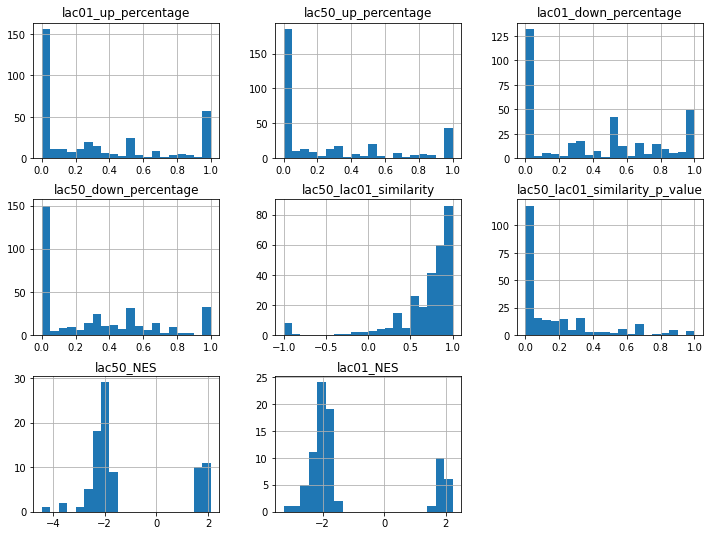

In [46]:
pwy_merge_df.hist(figsize=(12,9), bins=20)

### 3.2 Merge pathway Names

In [47]:
pwy_merge_df_name = pd.merge(
    left = pwy_merge_df,
    right = pathway_gene_dict[["UNIQUE-ID", "NAME"]],
    how = "left",
    left_on = "pathway_id",
    right_on = "UNIQUE-ID"
).drop("UNIQUE-ID", axis = 1)
pwy_merge_df_name.head(3)

,pathway_id,lac01_up_percentage,lac50_up_percentage,lac01_down_percentage,lac50_down_percentage,lac50_lac01_similarity,lac50_lac01_similarity_p_value,lac50_NES,lac01_NES,NAME
0,BGALACT-PWY,1.0,0.0,0.000000,1.000000,NaN,NaN,NaN,NaN,lactose degradation III
1,DAPLYSINESYN-PWY,0.0,0.0,0.727273,0.454545,0.570285,0.066968,-2.107329,-1.975862,lysine biosynthesis I
2,PWY-1269,0.0,0.0,0.500000,0.500000,0.935484,0.006109,NaN,NaN,CMP-KDO biosynthesis I


### 3.3 Merge pathway Gene set number

In [48]:
def pwy_size(pwy_info):
    gene_set_size = []
    pwy_id_list = []
    i = 0
    while i<len(pwy_info):
        pwy_id = pwy_info.loc[i, "UNIQUE-ID"]
        gene_set = pwy_info.loc[i, "gene_all"].split(",")
        
        gene_set_size.append(len(gene_set))
        pwy_id_list.append(pwy_id)
        i = i+1
    pwy_size_df = pd.DataFrame({
        "pathway_id": pwy_id_list,
        "pwy_size": gene_set_size
    })
    
    return pwy_size_df

In [49]:
pwy_size_df = pwy_size(pathway_gene_nomissing)
pwy_size_df.head(3)

,pathway_id,pwy_size
0,BGALACT-PWY,1
1,DAPLYSINESYN-PWY,11
2,PWY-1269,6


array([[<AxesSubplot:title={'center':'pwy_size'}>]], dtype=object)

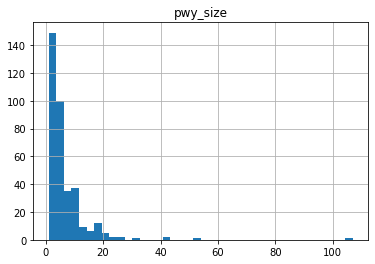

In [50]:
pwy_size_df.hist(bins = 40)

In [51]:
pwy_merge_df_name_size = pd.merge(
    left = pwy_merge_df_name,
    right = pwy_size_df,
    how = "left",
    on = "pathway_id"
)
pwy_merge_df_name_size.head(3)

,pathway_id,lac01_up_percentage,lac50_up_percentage,lac01_down_percentage,lac50_down_percentage,lac50_lac01_similarity,lac50_lac01_similarity_p_value,lac50_NES,lac01_NES,NAME,pwy_size
0,BGALACT-PWY,1.0,0.0,0.000000,1.000000,NaN,NaN,NaN,NaN,lactose degradation III,1
1,DAPLYSINESYN-PWY,0.0,0.0,0.727273,0.454545,0.570285,0.066968,-2.107329,-1.975862,lysine biosynthesis I,11
2,PWY-1269,0.0,0.0,0.500000,0.500000,0.935484,0.006109,NaN,NaN,CMP-KDO biosynthesis I,6


In [52]:
pwy_merge_df_name_size

,pathway_id,lac01_up_percentage,lac50_up_percentage,lac01_down_percentage,lac50_down_percentage,lac50_lac01_similarity,lac50_lac01_similarity_p_value,lac50_NES,lac01_NES,NAME,pwy_size
0,BGALACT-PWY,1.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,lactose degradation III,1
1,DAPLYSINESYN-PWY,0.000000,0.000000,0.727273,0.454545,0.570285,6.696765e-02,-2.107329,-1.975862,lysine biosynthesis I,11
2,PWY-1269,0.000000,0.000000,0.500000,0.500000,0.935484,6.109228e-03,NaN,NaN,CMP-KDO biosynthesis I,6
3,CYANCAT-PWY,0.666667,0.333333,0.333333,0.333333,1.000000,0.000000e+00,NaN,NaN,cyanate degradation,3
4,PWY0-461,0.500000,1.000000,0.000000,0.000000,-1.000000,NaN,NaN,NaN,lysine degradation I,2
5,ASPARAGINE-BIOSYNTHESIS,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,asparagine biosynthesis I,1
6,ASPARAGINESYN-PWY,0.000000,0.500000,1.000000,0.000000,1.000000,NaN,NaN,NaN,asparagine biosynthesis II,2
7,PWY-6519,0.000000,0.125000,0.500000,0.625000,0.580573,1.313044e-01,NaN,NaN,8-amino-7-oxononanoate biosynthesis I,8
8,PWY-6268,0.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,adenosylcobalamin salvage from cobalamin,1
9,PWY0-1479,0.000000,0.000000,0.750000,0.625000,0.809953,1.480723e-02,-2.214798,-1.954340,tRNA processing,8


### 3.4 Save the final dataframe

For pathways that are small, meaning the pathways size is 1-2, is excluded from enrichment. Thus I would like to figure out if the pathways are enriched in those 1/2 gene pathway. 

If:
    
    The gene is sig, then the NES is the LFC
    The avg.gene is sig, then the NES is the avg.lfc

In [53]:
def small_path_NES(de_con, col_name):
    # calc avg of lfc for sig regulated genes in the pathway
    for inx in pwy_merge_df_name_size.index:
        if pwy_merge_df_name_size.loc[inx,"pwy_size"]<3:
            pwy_id = pwy_merge_df_name_size.loc[inx, "pathway_id"]
            gene_list = pathway_gene_dict.loc[pathway_gene_dict["UNIQUE-ID"]==pwy_id,"gene_all"].values[0].split(",")
            #print(gene_list)
            lfc_list = []
            for gene in gene_list:
                lfc = de_con.loc[de_con["Unnamed: 0"]==gene,"log2FoldChange"].values[0]
                padj = de_con.loc[de_con["Unnamed: 0"]==gene,"padj"].values[0]
                if padj<0.05:
                    lfc_list.append(lfc)
            if len(lfc_list)>0:
                avg_lfc = np.mean(lfc_list)
                if np.abs(avg_lfc)>1:
                    pwy_merge_df_name_size.loc[inx,col_name] = avg_lfc
            

In [54]:
small_path_NES(lac01_vs_lac25_de, "lac01_NES")
small_path_NES(lac50_vs_lac25_de, "lac50_NES")

In [55]:
pwy_merge_df_name_size

,pathway_id,lac01_up_percentage,lac50_up_percentage,lac01_down_percentage,lac50_down_percentage,lac50_lac01_similarity,lac50_lac01_similarity_p_value,lac50_NES,lac01_NES,NAME,pwy_size
0,BGALACT-PWY,1.000000,0.000000,0.000000,1.000000,NaN,NaN,-1.952792,1.068988,lactose degradation III,1
1,DAPLYSINESYN-PWY,0.000000,0.000000,0.727273,0.454545,0.570285,6.696765e-02,-2.107329,-1.975862,lysine biosynthesis I,11
2,PWY-1269,0.000000,0.000000,0.500000,0.500000,0.935484,6.109228e-03,NaN,NaN,CMP-KDO biosynthesis I,6
3,CYANCAT-PWY,0.666667,0.333333,0.333333,0.333333,1.000000,0.000000e+00,NaN,NaN,cyanate degradation,3
4,PWY0-461,0.500000,1.000000,0.000000,0.000000,-1.000000,NaN,1.351552,1.839280,lysine degradation I,2
5,ASPARAGINE-BIOSYNTHESIS,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,-2.162875,asparagine biosynthesis I,1
6,ASPARAGINESYN-PWY,0.000000,0.500000,1.000000,0.000000,1.000000,NaN,NaN,-1.960279,asparagine biosynthesis II,2
7,PWY-6519,0.000000,0.125000,0.500000,0.625000,0.580573,1.313044e-01,NaN,NaN,8-amino-7-oxononanoate biosynthesis I,8
8,PWY-6268,0.000000,0.000000,1.000000,1.000000,NaN,NaN,-1.132560,-1.937679,adenosylcobalamin salvage from cobalamin,1
9,PWY0-1479,0.000000,0.000000,0.750000,0.625000,0.809953,1.480723e-02,-2.214798,-1.954340,tRNA processing,8


In [56]:
cols = pwy_merge_df_name_size.columns

for c in cols:
    
    if "similarity" in c:
        pwy_merge_df_name_size[c].fillna("NC", inplace = True)

In [57]:
pwy_merge_df_name_size

,pathway_id,lac01_up_percentage,lac50_up_percentage,lac01_down_percentage,lac50_down_percentage,lac50_lac01_similarity,lac50_lac01_similarity_p_value,lac50_NES,lac01_NES,NAME,pwy_size
0,BGALACT-PWY,1.000000,0.000000,0.000000,1.000000,NC,NC,-1.952792,1.068988,lactose degradation III,1
1,DAPLYSINESYN-PWY,0.000000,0.000000,0.727273,0.454545,0.570285,0.066968,-2.107329,-1.975862,lysine biosynthesis I,11
2,PWY-1269,0.000000,0.000000,0.500000,0.500000,0.935484,0.006109,NaN,NaN,CMP-KDO biosynthesis I,6
3,CYANCAT-PWY,0.666667,0.333333,0.333333,0.333333,1.0,0.0,NaN,NaN,cyanate degradation,3
4,PWY0-461,0.500000,1.000000,0.000000,0.000000,-1.0,NC,1.351552,1.839280,lysine degradation I,2
5,ASPARAGINE-BIOSYNTHESIS,0.000000,0.000000,1.000000,0.000000,NC,NC,NaN,-2.162875,asparagine biosynthesis I,1
6,ASPARAGINESYN-PWY,0.000000,0.500000,1.000000,0.000000,1.0,NC,NaN,-1.960279,asparagine biosynthesis II,2
7,PWY-6519,0.000000,0.125000,0.500000,0.625000,0.580573,0.131304,NaN,NaN,8-amino-7-oxononanoate biosynthesis I,8
8,PWY-6268,0.000000,0.000000,1.000000,1.000000,NC,NC,-1.132560,-1.937679,adenosylcobalamin salvage from cobalamin,1
9,PWY0-1479,0.000000,0.000000,0.750000,0.625000,0.809953,0.014807,-2.214798,-1.954340,tRNA processing,8


In [58]:
pwy_merge_final = pwy_merge_df_name_size.sort_values(["lac50_up_percentage", "lac50_down_percentage"], ascending=[False, True]).fillna(0)
pwy_merge_final.head(3)

,pathway_id,lac01_up_percentage,lac50_up_percentage,lac01_down_percentage,lac50_down_percentage,lac50_lac01_similarity,lac50_lac01_similarity_p_value,lac50_NES,lac01_NES,NAME,pwy_size
4,PWY0-461,0.5,1.0,0.0,0.0,-1.0,NC,1.351552,1.839280,lysine degradation I,2
20,PWY-6019,1.0,1.0,0.0,0.0,1.0,NC,3.234241,2.697386,pseudouridine degradation,2
35,PWY0-1324,1.0,1.0,0.0,0.0,0.5,0.666667,0.000000,0.000000,<i>N</i>-acetylneuraminate and <i>N</i>-acetylmannosamine degradation,3


In [61]:
pwy_merge_final.to_csv("(no amp)EnrichFiles/PathEnrich_summary/pathway_enrich_meta_50base.csv")

In [62]:
pwy_merge_final2 = pwy_merge_df_name_size.sort_values(["lac01_up_percentage", "lac01_down_percentage"], ascending=[False, True]).fillna(0)
pwy_merge_final2.head(3)

,pathway_id,lac01_up_percentage,lac50_up_percentage,lac01_down_percentage,lac50_down_percentage,lac50_lac01_similarity,lac50_lac01_similarity_p_value,lac50_NES,lac01_NES,NAME,pwy_size
0,BGALACT-PWY,1.0,0.000000,0.0,1.0,NC,NC,-1.952792,1.068988,lactose degradation III,1
10,FAO-PWY,1.0,0.888889,0.0,0.0,-0.066667,0.86469,0.000000,2.223878,fatty acid &beta;-oxidation I,9
12,PWY0-1337,1.0,0.000000,0.0,0.0,NC,NC,0.000000,3.747271,oleate &beta;-oxidation,1


In [63]:
pwy_merge_final2.to_csv("(no amp)EnrichFiles/PathEnrich_summary/pathway_enrich_meta_01base.csv")

In [64]:
pwy_merge_final.shape, pwy_merge_final2.shape

((362, 11), (362, 11))